In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

/home/dharmraj/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("sentiment_analysis.csv")
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [4]:
df.drop(["Day", 'Year', 'Month', 'Time of Tweet', 'Platform'], inplace=True, axis=1)

In [5]:
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative


In [6]:
df["sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
lb = LabelEncoder()
df["label_sentiment"] = lb.fit_transform(df["sentiment"])

In [9]:
df.head()

,text,sentiment,label_sentiment
0,What a great day!!! Looks like dream.,positive,2
1,"I feel sorry, I miss you here in the sea beach",positive,2
2,Don't angry me,negative,0
3,We attend in the class just for listening teac...,negative,0
4,"Those who want to go, let them go",negative,0


In [10]:
df.isnull().sum()

text               0
sentiment          0
label_sentiment    0
dtype: int64

In [11]:
df["sentiment"].value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [12]:
import matplotlib.pyplot as plt

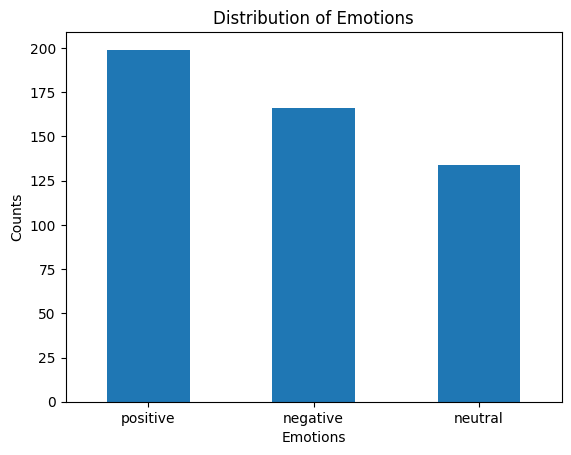

In [13]:
value_counts = df["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['positive', 'negative', 'neutral'], rotation=0)

plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Counts')

plt.show()

In [14]:
df

,text,sentiment,label_sentiment
0,What a great day!!! Looks like dream.,positive,2
1,"I feel sorry, I miss you here in the sea beach",positive,2
2,Don't angry me,negative,0
3,We attend in the class just for listening teac...,negative,0
4,"Those who want to go, let them go",negative,0
...,...,...,...
494,"According to , a quarter of families under six...",negative,0
495,the plan to not spend money is not going well,negative,0
496,uploading all my bamboozle pictures of facebook,neutral,1
497,congratulations ! you guys finish a month ear...,positive,2


In [15]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label_sentiment'], train_size=0.80, shuffle = True)

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [17]:
train_tokens = tokenizer(list(x_train), padding = True, truncation=True)
test_tokens = tokenizer(list(x_test), padding = True, truncation=True)

In [18]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [19]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[101, 2065, 2069, 2057, 2071, 2412, 2941, 2022, 3039, 2000, 2994, 2182, 1998, 2079, 2008, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] if only we could ever actually be allowed to stay here and do that [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [20]:
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = x_train
            self.tokens = train_tokens
            self.labels = list(y_train)
        else:
            self.text_data = x_test
            self.tokens = test_tokens
            self.labels = list(y_test)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

In [21]:
batch_size = 8
train_dataset = TokenData(train = True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TokenData(train = False)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [22]:
num_classes = 9
bert_model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes) 
optimizer = AdamW(bert_model.parameters(), lr=1e-5) 
loss_fn = torch.nn.CrossEntropyLoss()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [23]:
torch.cuda.empty_cache()

In [24]:
torch.cuda.is_available()

/home/dharmraj/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [25]:
num_epochs = 5
device = "cuda"
bert_model.to(device) # Transfer model to GPU if available

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
accumulation_steps = 4


for epoch in range(num_epochs):
    print("Epoch: ", (epoch + 1))
    bert_model.train()
    optimizer.zero_grad()

    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Check for out-of-bound labels
        if (batch['labels'] >= num_classes).any():
            print(f"Out-of-bound label found in batch {i+1}: ", batch['labels'])
            continue  # Skip this batch

        with autocast():
            outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            pred = outputs.logits

            # Debugging prints
            #print(f"Batch {i+1}: input_ids.shape = {batch['input_ids'].shape}, pred.shape = {pred.shape}, labels.shape = {batch['labels'].shape}")

            loss = loss_fn(pred, batch['labels'])

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        train_batch_loss = loss.item()
        train_last_loss = train_batch_loss / batch['input_ids'].size(0)
        print(f'Training batch {i + 1} last loss: {train_last_loss}')

    print(f"\nTraining epoch {epoch + 1} loss: ", train_last_loss)

    bert_model.eval()
    correct = 0
    for i, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            with autocast():
                outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            logits = outputs.logits
            loss = loss_fn(logits, batch['labels'])
            test_batch_loss = loss.item()
            test_last_loss = test_batch_loss / batch['input_ids'].size(0)
            #print(f'Testing batch {i + 1} loss: {test_last_loss}')

            correct += (logits.argmax(1) == batch['labels']).sum().item()
            print(f"Testing accuracy: {correct / ((i + 1) * batch['input_ids'].size(0))}")

    print(f"\nTesting epoch {epoch + 1} last loss: ", test_last_loss)

In [ ]:
bert_model.eval()

In [ ]:
model_senti = torch.save(bert_model, "BERTsentiment")

In [ ]:
from transformers import pipeline

In [ ]:
clf = pipeline("text-classification", model_senti, device=device)
answer = clf("text")

In [ ]:
print(answer)

In [ ]:
clf("Oh my God!")

In [ ]:
clf("I am sorry")

In [ ]:
clf("He put the car in neutral", return_all_scores=True)

In [ ]:
clf("There is a book on the desk", return_all_scores=True)